# Fine Tuning BERT for Sentiment Analysis with PyTorch

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = True  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


## Installing and Importing Required Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
PRETRAINED_MODEL_PATH = "neuralmind/bert-base-portuguese-cased"
BERTIMBAU_HIDDEN_SIZE = 768

SAMPLE_REVIEWS = [
    "Empresa boa para trabalhar", # positive
    "Empresa ruim para trabalhar", # negative
    "Não tenho o que declarar", # neutral
]


if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-dropout.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-dropout-freezing.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-dropout.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = (
        "/kaggle/working/bertimbau-glassdoor-reviews-dropout-freezing.bin"
    )
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-dropout.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "./bertimbau-glassdoor-reviews-dropout-freezing.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [6]:
torch.manual_seed(RANDOM_SEED)

In [7]:
random.seed(RANDOM_SEED)

In [8]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [9]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [10]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1


In [11]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [12]:
filtered_dataset.shape

(2532, 2)

In [13]:
filtered_dataset["sentiment"].value_counts()

,count
sentiment,
1,1269
-1,1021
0,242


In [14]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [15]:
num_labels

3

In [16]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [17]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [18]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [19]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [20]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [21]:
train_data.shape

(2025, 2)

In [22]:
test_data.shape

(507, 2)

## Loading Bertimbau model

In [23]:
bertimbau = BertModel.from_pretrained(PRETRAINED_MODEL_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [24]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Create a PyTorch Dataset

In [25]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer, token_max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = token_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [26]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer, TOKEN_MAX_LENGTH)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer, TOKEN_MAX_LENGTH)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [28]:
classifier = nn.Sequential(
    nn.Linear(BERTIMBAU_HIDDEN_SIZE, 300),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(50, num_labels),
)

In [29]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_PATH)
        self.classifier = classifier


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

In [30]:
class GlassdoorReviewsClassifierFreezing(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifierFreezing, self).__init__()

        for param in bertimbau.parameters():
            param.requires_grad = False

        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_PATH)
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [31]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [32]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [33]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch, title):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [34]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []
    start_time = time.time()

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

    return train_losses, test_losses

## Model Evaluation functions

In [35]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [36]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [37]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

In [38]:
model = GlassdoorReviewsClassifier(num_labels).to(device)
model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [39]:
loss_fun = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_freezing = torch.optim.Adam(model_freezing.parameters(), lr=LEARNING_RATE)

In [41]:
n_total_steps = len(train_loader)
n_total_steps

127

### Training Model without freezing BERT Layers

In [42]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 1.0523
Training Batch 32/127, 		 loss = 1.0289
Training Batch 48/127, 		 loss = 0.9375
Training Batch 64/127, 		 loss = 0.7889
Training Batch 80/127, 		 loss = 0.7840
Training Batch 96/127, 		 loss = 0.5995
Training Batch 112/127, 		 loss = 0.8995

Evaluating Batch 16/127, 		 loss = 0.5649
Evaluating Batch 32/127, 		 loss = 0.5731

Train Loss: 0.8362731112269904, 		 Test Loss: 0.5058200312778354



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.5839
Training Batch 32/127, 		 loss = 0.5849
Training Batch 48/127, 		 loss = 0.3605
Training Batch 64/127, 		 loss = 0.2614
Training Batch 80/127, 		 loss = 0.2500
Training Batch 96/127, 		 loss = 0.4346
Training Batch 112/127, 		 loss = 0.1517

Evaluating Batch 16/127, 		 loss = 0.6612
Evaluating Batch 32/127, 		 loss = 0.1704

Train Loss: 0.4031110687518683, 		 Test Loss: 0.29887785809114575



-------------------- Ep

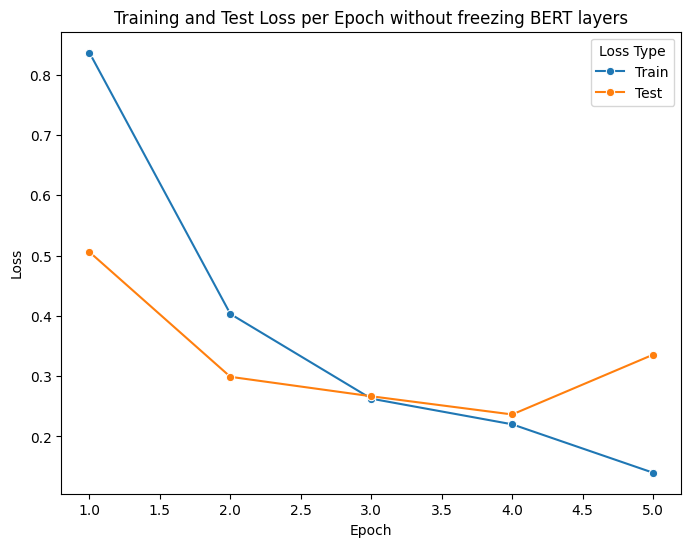

In [43]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch without freezing BERT layers")

#### Evaluating the Model

In [44]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [45]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        51
           1       0.91      0.98      0.94       269
           2       0.98      0.85      0.91       187

    accuracy                           0.91       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.92      0.91      0.91       507



In [46]:
print(accuracy_score(all_labels, all_preds))

0.9112426035502958


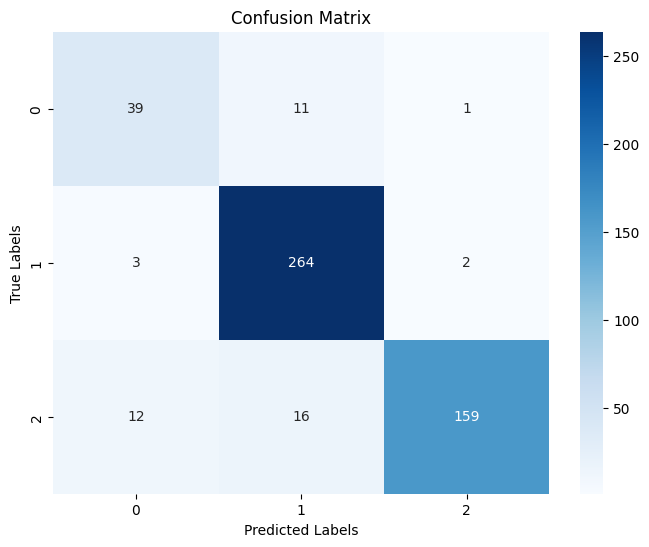

In [47]:
show_confusion_matrix(all_labels, all_preds)

In [48]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [49]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout.bin")

#### Loading the model

In [50]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

<ipython-input-50-943f1caec82f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))


GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

#### Sample prediction

In [51]:
predict_reviews(model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.005528
positive    0.991380
negative    0.003092
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.017923
positive    0.960485
negative    0.021592
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.836151
positive    0.072977
negative    0.090872
Name: 0, dtype: float64




### Training Model freezing BERT Layers

In [52]:
train_losses, test_losses = start_training(
    model_freezing, train_loader, loss_fun, optimizer_freezing, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 0.6463
Training Batch 32/127, 		 loss = 0.4987
Training Batch 48/127, 		 loss = 0.8549
Training Batch 64/127, 		 loss = 0.3121
Training Batch 80/127, 		 loss = 0.2092
Training Batch 96/127, 		 loss = 0.3091
Training Batch 112/127, 		 loss = 0.0803

Evaluating Batch 16/127, 		 loss = 0.2312
Evaluating Batch 32/127, 		 loss = 0.0713

Train Loss: 0.4099200659497516, 		 Test Loss: 0.22403969638980925



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.1773
Training Batch 32/127, 		 loss = 0.3105
Training Batch 48/127, 		 loss = 0.0838
Training Batch 64/127, 		 loss = 0.0363
Training Batch 80/127, 		 loss = 0.1151
Training Batch 96/127, 		 loss = 0.2650
Training Batch 112/127, 		 loss = 0.2379

Evaluating Batch 16/127, 		 loss = 0.6089
Evaluating Batch 32/127, 		 loss = 0.0357

Train Loss: 0.18057569946477733, 		 Test Loss: 0.20550529845058918



-------------------- 

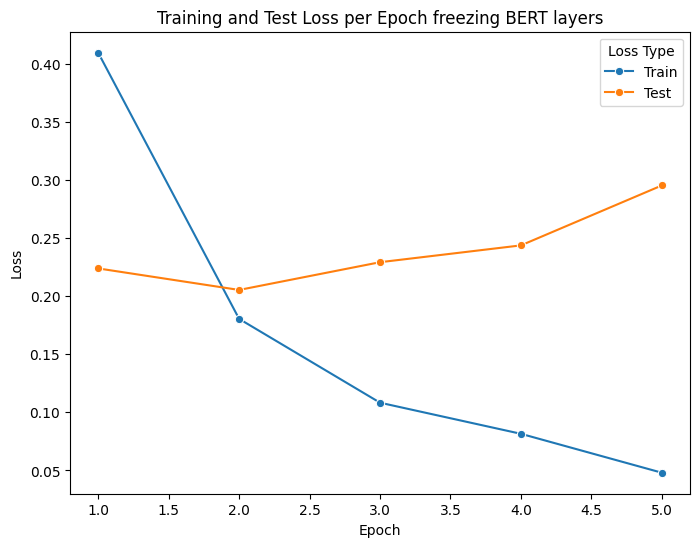

In [53]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch freezing BERT layers")

#### Evaluating the Model

In [54]:
all_labels, all_preds = evaluate_model(model_freezing, test_loader, device)

In [55]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80        51
           1       0.94      0.96      0.95       269
           2       0.97      0.93      0.95       187

    accuracy                           0.93       507
   macro avg       0.90      0.90      0.90       507
weighted avg       0.93      0.93      0.93       507



In [56]:
print(accuracy_score(all_labels, all_preds))

0.9329388560157791


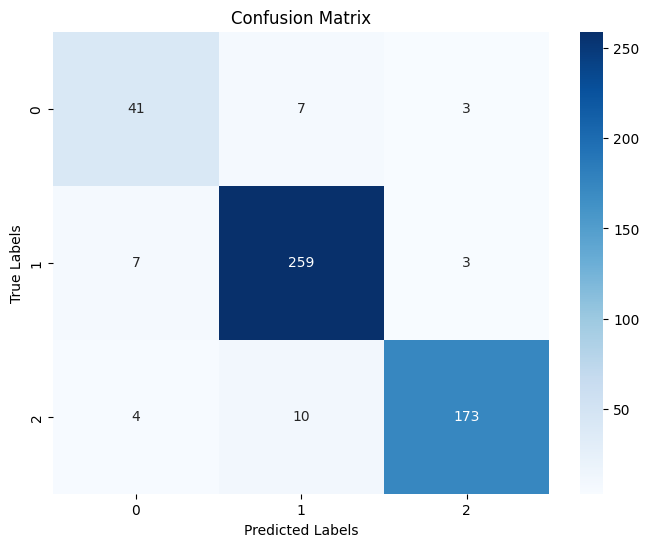

In [57]:
show_confusion_matrix(all_labels, all_preds)

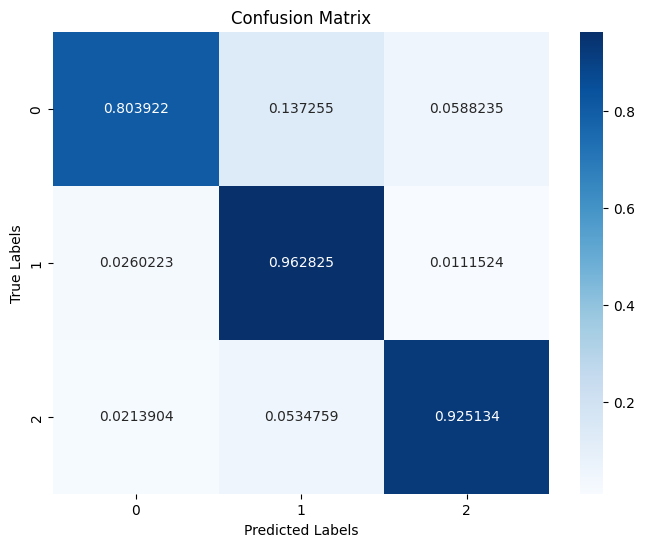

In [58]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [59]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-freezing.bin")

#### Loading the model

In [60]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_FREEZING_MODEL_PATH, map_location=device))
loaded_model.eval()

<ipython-input-60-9eb54d819a40>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(GLASSDOOR_FREEZING_MODEL_PATH, map_location=device))

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [61]:
predict_reviews(loaded_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000517
positive    0.999276
negative    0.000207
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.003181
positive    0.992205
negative    0.004614
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.980470
positive    0.007865
negative    0.011664
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [62]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [63]:
filtered_dataset.shape

(2532, 2)

In [64]:
filtered_dataset["sentiment"].value_counts()

,count
sentiment,
1,1269
2,1021
0,242


In [65]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [66]:
oversampled_filtered_dataset.shape

(3258, 2)

In [67]:
oversampled_filtered_dataset["sentiment"].value_counts()

,count
sentiment,
1,1269
2,1021
0,968


### Training the Model

In [68]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [69]:
oversampled_train_dataset = GlassdoorReviewsDataset(
    oversampled_train_data, tokenizer, TOKEN_MAX_LENGTH
)

oversampled_test_dataset = GlassdoorReviewsDataset(
    oversampled_test_data, tokenizer, TOKEN_MAX_LENGTH
)

In [70]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [71]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [72]:
loss_fun = nn.CrossEntropyLoss()

In [73]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)
oversampled_optimizer_freezing = torch.optim.Adam(
    oversampled_model_freezing.parameters(), lr=LEARNING_RATE
)

In [74]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

163

#### Train without freezing

In [75]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 0.6384
Training Batch 32/163, 		 loss = 0.3861
Training Batch 48/163, 		 loss = 0.6414
Training Batch 64/163, 		 loss = 0.3477
Training Batch 80/163, 		 loss = 0.2354
Training Batch 96/163, 		 loss = 0.1018
Training Batch 112/163, 		 loss = 0.0601
Training Batch 128/163, 		 loss = 0.5199
Training Batch 144/163, 		 loss = 0.2593
Training Batch 160/163, 		 loss = 0.3862

Evaluating Batch 16/163, 		 loss = 0.1130
Evaluating Batch 32/163, 		 loss = 0.0176

Train Loss: 0.34205669066383065, 		 Test Loss: 0.12052873335778713



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 0.1086
Training Batch 32/163, 		 loss = 0.0614
Training Batch 48/163, 		 loss = 0.0731
Training Batch 64/163, 		 loss = 0.0126
Training Batch 80/163, 		 loss = 0.0475
Training Batch 96/163, 		 loss = 0.0517
Training Batch 112/163, 		 loss = 0.3441
Training Batch 128/163, 		 loss = 0.2080
Training Bat

##### Evaluating the Model

In [76]:
len(oversampled_train_losses)

5

In [77]:
len(oversampled_test_losses)

5

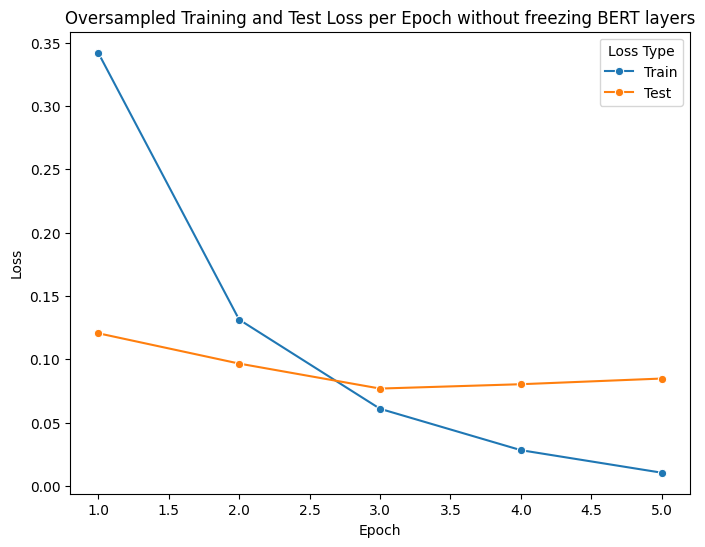

In [78]:
show_loss(oversampled_train_losses, oversampled_test_losses, title="Oversampled Training and Test Loss per Epoch without freezing BERT layers")

In [79]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [80]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       197
           1       0.95      0.96      0.95       256
           2       0.97      0.92      0.95       199

    accuracy                           0.95       652
   macro avg       0.95      0.95      0.95       652
weighted avg       0.95      0.95      0.95       652



In [81]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.9524539877300614


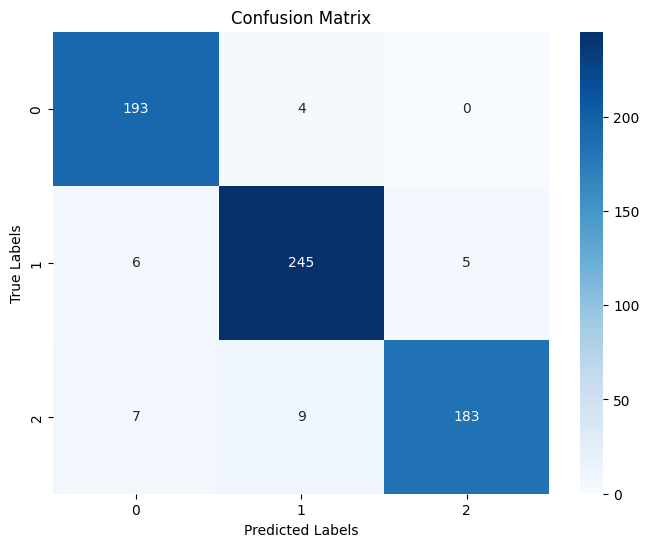

In [82]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [83]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-oversampled.bin",
)

##### Loading the model

In [84]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-droupout.bin",
            f"bertimbau-glassdoor-reviews-droupout-oversampled.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

<ipython-input-84-0620da4835b9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [85]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.005528
positive    0.991380
negative    0.003092
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.017923
positive    0.960485
negative    0.021592
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.836151
positive    0.072977
negative    0.090872
Name: 0, dtype: float64




#### Train freezing

In [86]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model_freezing,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer_freezing,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 0.5985
Training Batch 32/163, 		 loss = 0.3745
Training Batch 48/163, 		 loss = 0.2646
Training Batch 64/163, 		 loss = 0.3750
Training Batch 80/163, 		 loss = 0.2161
Training Batch 96/163, 		 loss = 0.6334
Training Batch 112/163, 		 loss = 0.1909
Training Batch 128/163, 		 loss = 0.3533
Training Batch 144/163, 		 loss = 0.2816
Training Batch 160/163, 		 loss = 0.2244

Evaluating Batch 16/163, 		 loss = 0.0564
Evaluating Batch 32/163, 		 loss = 0.0405

Train Loss: 0.42737993479140696, 		 Test Loss: 0.13165241468232125



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 0.1914
Training Batch 32/163, 		 loss = 0.0715
Training Batch 48/163, 		 loss = 0.2728
Training Batch 64/163, 		 loss = 0.1083
Training Batch 80/163, 		 loss = 0.2005
Training Batch 96/163, 		 loss = 0.0447
Training Batch 112/163, 		 loss = 0.0714
Training Batch 128/163, 		 loss = 0.0679
Training Bat

##### Evaluating the Model

In [87]:
len(oversampled_train_losses)

5

In [88]:
len(oversampled_test_losses)

5

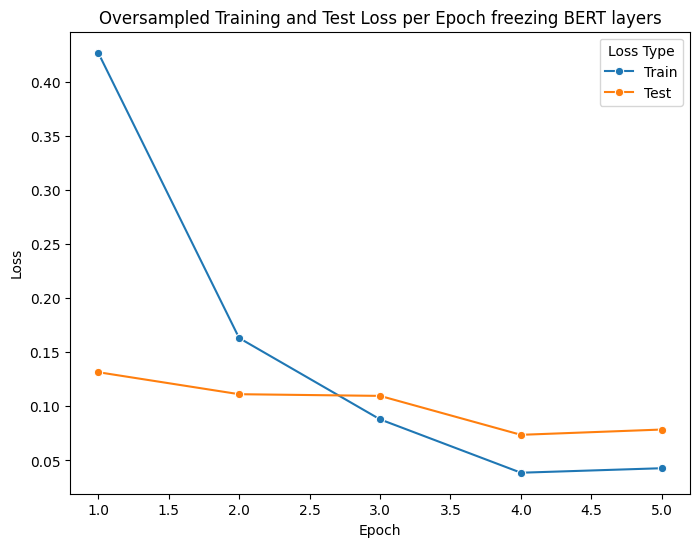

In [89]:
show_loss(
    oversampled_train_losses,
    oversampled_test_losses,
    title="Oversampled Training and Test Loss per Epoch freezing BERT layers",
)

In [90]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model_freezing, oversampled_test_loader, device
)

In [91]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       197
           1       0.95      0.95      0.95       256
           2       0.97      0.93      0.95       199

    accuracy                           0.96       652
   macro avg       0.96      0.96      0.96       652
weighted avg       0.96      0.96      0.96       652



In [92]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.9555214723926381


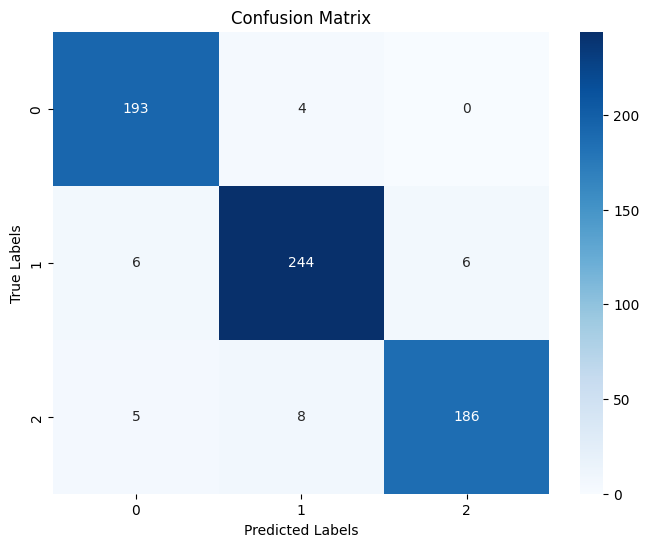

In [93]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [94]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-oversampled-freezing.bin",
)

##### Loading the model

In [95]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-dropout.bin",
            f"bertimbau-glassdoor-reviews-dropout-oversampled-freezing.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

<ipython-input-95-a72636afb7d2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [96]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000459
positive    0.999365
negative    0.000177
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.003128
positive    0.992207
negative    0.004665
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.996201
positive    0.001987
negative    0.001812
Name: 0, dtype: float64


